In [1]:
import sys; sys.path.insert(0,'../'); sys.path.insert(0,'../../mac/');sys.path.insert(0,'../../../../ndtest/');
from notebook_tools import *
from scipy.stats import ks_2samp
from scipy.stats import norm
from scipy.stats import kurtosis
#import ndtest
%matplotlib inline
# redirect output to the systems standard output 
# sys.stdout = open('/dev/stdout', 'w')

Welcome to ROOTaaS 6.06/02

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



/usr/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Error in <TProtoClass::FindDataMember>: data member with index 0 is not found in class locale
Error in <CreateRealData>: Cannot find data member # 0 of class locale for parent GenerateEvents!
Error in <TProtoClass::FindDataMember>: data member with index 0 is not found in class locale
Error in <CreateRealData>: Cannot find data member # 0 of class locale for parent GenerateEvents!
Error in <TProtoClass::FindDataMember>: data member with index 0 is not found in class locale
Error in <CreateRealData>: Cannot find data member # 0 of class locale for parent GenerateEvents!


In [2]:
scheme = TSchemeDATA()
targets = ['C12','Al27','Fe56','Pb208']
PmissBins   = [[0.3,0.45]  , [0.45,0.55] , [0.55,0.65]  , [0.65,0.75] , [0.75,1.0]]
Pmiss3Bins  = [[0.3,0.52]  , [0.52,0.68]  , [0.68,1.0]]
path = "/Users/erezcohen/Desktop/DataMining"
ppPath = path + "/Analysis_DATA/ppSRCcm"

In [3]:
cm_pars , cm_fits = dict() , dict()
ana_data = dict()

for target in targets:
    cm_pars[target] = pd.read_csv( ppPath+'/DATA/%s_dataCMparameters.csv'%target ) 
    ana_data[target] = TAnalysisEG2( path+"/AnaFiles" ,  "Ana_ppSRCCut_DATA_%s"%target )

In [4]:
def a1a2_create_negative_sigma_z( a1 , a2 ):
    '''
    check if a1 and a2 give \sigma_z < 0,
    since we do not want to use those (unreasonable) values.
    we check for the minimal Pmiss (0.3) and the maximal Pmiss (1.0)
    '''
    if a1*(0.3 - 0.6) + a2 < 0: return True
    if a1*(1.0 - 0.6) + a2 < 0: return True
    return False


In [5]:
def calc_cm_parameters( fana  , PmissBins , unweightedRoofitsFName = '' , weightedRoofitsFName = '' , DoSaveCanvas = False ):
    '''
        Return: df_pMissBin , do_fits (continue or not)
        '''
    do_fits = True
    df_pMissBins = pd.DataFrame()
    
    if fana.GetEntries()==0:
        print 'no entries in anaTree of',fana.GetFileName()
        print 'leaving calc_cm_parameters'
        return pd.DataFrame() , False

    ana = read_root( str(fana.GetFileName()) , key='anaTree' , columns=['pcmX','pcmY','pcmZ','Pmiss3Mag','rooWeight']  )

    for i in range(len(PmissBins)):
        pMiss_min , pMiss_max = PmissBins[i][0] , PmissBins[i][1]
        ana_reduced = ana[ (pMiss_min < ana.Pmiss3Mag) & (ana.Pmiss3Mag < pMiss_max) ]
        good_bin = True if len(ana_reduced)>0 else False
        print 'calculating parameters for p(miss) bin ',i,',',pMiss_min,' to ',pMiss_max,' GeV/c, ',len(ana_reduced),'events in this bin'

        if len(ana_reduced)>0 and sum(ana_reduced.rooWeight)>0:
            good_bin , sqrtN = 1 , sqrt(len(ana_reduced))
            mean_x_unweighted , mean_x_weighted     = np.average( ana_reduced.pcmX ) , np.average( ana_reduced.pcmX , weights=ana_reduced.rooWeight )
            sigma_x_unweighted, sigma_x_weighted    = np.sqrt(np.average( np.square(ana_reduced.pcmX-mean_x_unweighted) )) , np.sqrt(np.average( np.square(ana_reduced.pcmX-mean_x_weighted) , weights=ana_reduced.rooWeight  ))
            mean_y_unweighted , mean_y_weighted     = np.average( ana_reduced.pcmY ) , np.average( ana_reduced.pcmY , weights=ana_reduced.rooWeight )
            sigma_y_unweighted, sigma_y_weighted    = np.sqrt(np.average( np.square(ana_reduced.pcmY-mean_y_unweighted) )) , np.sqrt(np.average( np.square(ana_reduced.pcmY-mean_y_weighted) , weights=ana_reduced.rooWeight  ))
            mean_z_unweighted , mean_z_weighted     = np.average( ana_reduced.pcmZ ) , np.average( ana_reduced.pcmZ , weights=ana_reduced.rooWeight )
            sigma_z_unweighted, sigma_z_weighted    = np.sqrt(np.average( np.square(ana_reduced.pcmZ-mean_z_unweighted) )) , np.sqrt(np.average( np.square(ana_reduced.pcmZ-mean_z_weighted) , weights=ana_reduced.rooWeight  ))
        else:
            good_bin , sqrtN , do_fits  = 0 , 1 , False
            mean_x_unweighted , mean_x_weighted     = -100,-100
            sigma_x_unweighted, sigma_x_weighted    = -100,-100
            mean_y_unweighted , mean_y_weighted     = -100,-100
            sigma_y_unweighted, sigma_y_weighted    = -100,-100
            mean_z_unweighted , mean_z_weighted     = -100,-100
            sigma_z_unweighted, sigma_z_weighted    = -100,-100


        df_pMissBin = pd.DataFrame({'pMiss_min':pMiss_min                   ,'pMiss_max':pMiss_max
                                   ,'EvtsInBin':len(ana_reduced)            ,'good_bin':good_bin
                                   ,'mean_x_unweighted':mean_x_unweighted   ,'mean_xErr_unweighted':sigma_x_unweighted/sqrtN ,'sigma_x_unweighted':sigma_x_unweighted,'sigma_xErr_unweighted':0.02 # resolution uncertainty
                                    ,'mean_y_unweighted':mean_y_unweighted   ,'mean_yErr_unweighted':sigma_y_unweighted/sqrtN ,'sigma_y_unweighted':sigma_y_unweighted,'sigma_yErr_unweighted':0.02 # resolution uncertainty0
                                   ,'mean_z_unweighted':mean_z_unweighted   ,'mean_zErr_unweighted':sigma_z_unweighted/sqrtN ,'sigma_z_unweighted':sigma_z_unweighted,'sigma_zErr_unweighted':0.02 # resolution uncertainty
                                   ,'mean_x_weighted':mean_x_weighted       ,'mean_xErr_weighted':sigma_x_weighted/sqrtN     ,'sigma_x_weighted':sigma_x_weighted    ,'sigma_xErr_weighted':0.02 # resolution uncertainty
                                   ,'mean_y_weighted':mean_y_weighted       ,'mean_yErr_weighted':sigma_y_weighted/sqrtN     ,'sigma_y_weighted':sigma_y_weighted    ,'sigma_yErr_weighted':0.02 # resolution uncertainty
                                    ,'mean_z_weighted':mean_z_weighted       ,'mean_zErr_weighted':sigma_z_weighted/sqrtN     ,'sigma_z_weighted':sigma_z_weighted    ,'sigma_zErr_weighted':0.02 # resolution uncertainty
                                   }, index=[i])
        df_pMissBins = df_pMissBins.append(df_pMissBin)

    print "computed cm parameters for "+fana.InFileName
    print "reconstructed cm parameters"
    garbage_list = [ ana ]
    del garbage_list
    return df_pMissBins , do_fits

In [6]:
def linear_06(x, slope, intercept):
    return slope * ( x - 0.6 ) + intercept

def fit_as_a_function_of_pmiss( x , y , yerr=None, fit_type='const' , title='', x_offset=0.6): # the main fitting routine
    
    if fit_type=='const':
        if len(x)<3:return -100 , 0
        p1,v1 = np.polyfit( x , y , 0 , cov=True)
        chi2red = -100
        if not p1 or not v1 or len(p1)==0 or len(v1)==0:return -100 , 0
        else:
            return p1[0] , sqrt(v1[0,0]) , chi2red
    elif fit_type=='linear':
        if len(x)<4:return -100 , 0 , -100 , 0
        f = linear_06
        p2, v2 = curve_fit(f, xdata=x, ydata=y,sigma=yerr)# fit data using SciPy's Levenberg-Marquart method
        chi2red = (np.sum( np.square( (np.polyval(p2, x) - y) / yerr ) ))/(len(x) - 2)
        if p2 is None or v2 is None or p2 is np.inf or v2 is np.inf: return -100 , 0 , -100 , 0 , 0
        if p2[0] is np.inf or p2[1] is np.inf or v2[0,0] is np.inf or v2[1,1] is np.inf: return -100 , 0 , -100 , 0 , 0
        else:
            return p2[0] , sqrt(float(v2[0,0])) , p2[1] , sqrt(float(v2[1,1])) , chi2red

def fit_par_noplot( data , var , weight , title ): # a sub-routine to fit a single parameter; same as fit_par_plot without a plot
    # remove empty bins
    data = data[data['good_bin']==1]
    # fit x/y/z as a function of p(miss)
    Pmiss = (data.pMiss_max + data.pMiss_min)/2.
    pMissUpErr , pMissLowErr = data.pMiss_max - Pmiss , Pmiss - data.pMiss_min
    Xfit,XfitErr,Xchi2red = fit_as_a_function_of_pmiss( Pmiss, data[ var + '_x_' + weight] ,'const')
    Yfit,YfitErr,Ychi2red = fit_as_a_function_of_pmiss( Pmiss, data[ var + '_y_' + weight] ,'const')
    Za1,Za1err,Za2,Za2err,Zchi2red = fit_as_a_function_of_pmiss( Pmiss, data[ var + '_z_' + weight], data[ var + '_zErr_' + weight ],'linear')
    return [Xfit , XfitErr , Yfit , YfitErr, Za1 , Za1err , Za2 , Za2err , Zchi2red , None ]

def fit_cm_parameters( run , data , do_fits=True , FigureFName = '' , DoPlot = False ): # all parameters
    if do_fits==False:
        print 'nothing in cm-paramteres input as data to fit_cm_parameters()'
        print 'leaving fit_cm_parameters by appending -100 to all'
        return pd.DataFrame({ 'run':run,'Nevents':-100
                            ,'SigmaX':-100,'SigmaXerr':0,'MeanX':-100, 'MeanXerr':0
                            ,'SigmaY':-100,'SigmaYerr':0,'MeanY':-100,'MeanYerr':0
                            ,'a1':-100,'a1err':0,'a2':-100,'a2err':0,'a_chi2red':-100
                            ,'b1':-100,'b1err':0,'b2':-100,'b2err':0,'b_chi2red':-100
                            }, index=[0] )

    [SigmaX, SigmaXerr, SigmaY, SigmaYerr, a1, a1err, a2, a2err, a_chi2red, ax ] = fit_par_noplot ( data,'sigma','unweighted','\sigma' )
    [MeanX, MeanXerr, MeanY, MeanYerr, b1, b1err, b2, b2err, b_chi2red, ax ] = fit_par_noplot( data, 'mean','unweighted','mean')
    df_fit_parameters = pd.DataFrame({ 'run':run,'Nevents':(np.sum(data['EvtsInBin']))
                                     ,'SigmaX':SigmaX,'SigmaXerr':SigmaXerr,'MeanX':MeanX, 'MeanXerr':MeanXerr
                                     ,'SigmaY':SigmaY,'SigmaYerr':SigmaYerr,'MeanY':MeanY,'MeanYerr':MeanYerr
                                     ,'a1':a1,'a1err':a1err,'a2':a2,'a2err':a2err,'a_chi2red':a_chi2red
                                     ,'b1':b1,'b1err':b1err,'b2':b2,'b2err':b2err,'b_chi2red':b_chi2red
                                     }, index=[0] )
    print "computed fit parameters for run ",run
    print df_fit_parameters
    return df_fit_parameters

In [7]:
#         # compare x & y directions in 1 p(miss) bin - since there is no p(miss) dependence
#         Pval_KS = ndtest.ks2d2s(df_data['pcmX'] , df_data['pcmY'] , df_sim['pcmX'] , df_sim['pcmY'])
#         ks_pval_scores_target_array.append( Pval_KS )
#         ks_pval_scores_target['PvalTotalTransverse'] = Pval_KS
        
#         ax_t = fig_t.add_subplot(1 , 2 , 1 )
#         plot_2d_hist( df_data['pcmX'] , df_data['pcmY'] , xlabel='$p_{c.m.}^x$', ylabel='$p_{c.m.}^y$',cmap='jet',ax=ax_t , bins=(np.linspace(-0.5,0.5,50),np.linspace(-0.5,0.5,50)))
#         ax_t.set_title(target+' data, $\\sigma=%.3f,%.3f$ '%(np.std(df_data['pcmX']) , np.std(df_data['pcmY'])),y=1.01,fontsize=15)

#         ax_t = fig_t.add_subplot(1 , 2 , 2 )
#         plot_2d_hist( df_sim['pcmX'] , df_sim['pcmY'] , xlabel='$p_{c.m.}^x$', ylabel='$p_{c.m.}^y$',ax=ax_t, bins=(np.linspace(-0.5,0.5,50),np.linspace(-0.5,0.5,50)))
#         ax_t.set_title('simulation, $\\sigma=%.3f,%.3f$ (Pval=%f)'%(np.std(df_sim['pcmX']) , np.std(df_sim['pcmY']),Pval_KS),y=1.01,fontsize=15)        
        

def gauss(x,mu_0,sigma_0,A_0):
    return A_0*np.exp(-np.square(x-mu_0)/(2.*np.square(sigma_0)))

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

def calc_pval_ks_scores(ana_sim=None, ana_data=dict(),do_plots=True):
        
    ks_pval_scores = dict()
    # April-2017, change to Pval using ks-test
    df_sim = tree2array( ana_sim.GetTree() , branches=['pcmX','pcmY','pcmZ','Pmiss3Mag'] )
    
    for i_target,target in enumerate([targets[1]]): #{
        if do_plots:  # and target == 'C12'
            fig_t = plt.figure(figsize=(20,12))
            fig_l = plt.figure(figsize=(30,6))
        
        ks_pval_scores_target_array , ks_pval_scores_transverse_target_array , ks_pval_scores_longitudinal_target_array = [] , [] , []
        ks_pval_scores_target = dict()
        df_data = tree2array( ana_data[target].GetTree() , branches=['pcmX','pcmY','pcmZ','Pmiss3Mag'] )
        
        for i_dir,direction in enumerate(['X','Y']): #{
            x_data = df_data['pcm'+direction] # - np.mean(df_data['pcm'+direction])
            x_sim = df_sim['pcm'+direction]
            D_KS , Pval_KS = ks_2samp( x_data , x_sim )
            ks_pval_scores_target['pcm'+direction] = Pval_KS
            ks_pval_scores_target_array.append( Pval_KS )
            ks_pval_scores_transverse_target_array.append( Pval_KS )
            if do_plots:#{  and target == 'C12'
                ax_t = fig_t.add_subplot( 4 , 2 , 2*i_target + i_dir+1 )
                h,bins,_=ax_t.hist(x_sim , bins=25,label='sim. $\\mu=%.3f, \\sigma=%.3f$'%(np.mean(x_sim),np.std(x_sim)),histtype='step',linewidth=3,normed=1)
                h,bins,_=ax_t.hist(x_data , bins=bins,label=target+' data $\\mu=%.3f, \\sigma=%.3f$'%(np.mean(x_data),np.std(x_data)),histtype='step',linewidth=3,normed=1) 
                ax_t.legend(loc='best',fontsize=10)
                ax_t.set_title('$p_{c.m.}^{%s}$, Pval=%f'%(direction,Pval_KS),y=1.01,fontsize=15)
            #}                        
        #}
        ks_pval_scores_target['Pval_pcmX_pcmY'] = Fisher_combination_Pvals( [ks_pval_scores_target['pcmX'],ks_pval_scores_target['pcmY']] ) # with a cutoff on 1e-20

        # in z direction - compare in 5 bins of p(miss)
        for bin in range(len(PmissBins)):#{                
            pmin , pmax = PmissBins[bin][0] , PmissBins[bin][1]
            df_sim_reduced = df_sim[ (pmin < df_sim['Pmiss3Mag']) & (df_sim['Pmiss3Mag'] < pmax) ]
            df_data_reduced = df_data[ (pmin < df_data['Pmiss3Mag']) & (df_data['Pmiss3Mag'] < pmax) ]
            direction = 'Z'
            D_KS , Pval_KS = ks_2samp( df_sim_reduced['pcm'+direction] , df_data_reduced['pcm'+direction] )
            if do_plots:#{  and target == 'C12'
                ax_l = fig_l.add_subplot(1 , 5, bin+1 )
                bins=np.linspace(-0.5,2,50)
                hist , bin_edges = np.histogram (df_sim_reduced['pcm'+direction] , bins=bins , normed=1)
                x_bins=(bin_edges[1:]+bin_edges[:-1])/2 # for len(x)==len(y)
                params,cov=curve_fit(gauss,x_bins,hist,(np.mean(df_sim_reduced['pcm'+direction]),np.std(df_sim_reduced['pcm'+direction]),len(df_sim_reduced)))
                uncertaintes=np.sqrt(np.diag(cov))
                h,bins,_=ax_l.hist(df_sim_reduced['pcm'+direction] , bins=np.linspace(-0.5,2,50),histtype='step',linewidth=3,normed=1,label='sim. m=%f,\n s=%f'%(np.mean(df_sim_reduced['pcm'+direction]),np.std(df_sim_reduced['pcm'+direction])))

                fit_sigma_std_ratio = params[1]/np.std(df_sim_reduced['pcm'+direction])                
                print 'fit_sigma_std_ratio:' , fit_sigma_std_ratio
                if fit_sigma_std_ratio<0.75: Pval_KS=0                    
                plt.plot(x_bins,gauss(x_bins,*params),color='red',lw=3
                         ,label='fit m=%g\n+/-%g,\n s=%g\n+/-%g'%(params[0],uncertaintes[0],params[1],uncertaintes[1]))
                ax_l.hist(df_data_reduced['pcm'+direction] , bins=bins,label=target+' data',histtype='step',linewidth=3,normed=1) 
                ax_l.set_title('%.2f<$p_{miss}$<%.2f GeV/c, $p_{c.m.}^{%s}$ Pval=%f'%(pmin , pmax,direction,Pval_KS),y=1.01,fontsize=15)
                ax_l.legend(fontsize=15)
            #}
            ks_pval_scores_target['pcm'+direction+'_bin%d'%bin] = Pval_KS
            ks_pval_scores_target_array.append( Pval_KS )
            # local longitudinal and transverse p-values
            ks_pval_scores_longitudinal_target_array.append( Pval_KS )
        #}        
        ks_pval_scores_target['pcmZ'] = Fisher_combination_Pvals( ks_pval_scores_longitudinal_target_array ) # with a cutoff on 1e-20    
        ks_pval_scores_target['Pval_pcmX_pcmY_pcmZ'] = FisherMethodPvals( [ks_pval_scores_target['pcmX'],ks_pval_scores_target['pcmY'],ks_pval_scores_target['pcmZ']] )

        if do_plots and target == 'C12': plt.tight_layout()
        ks_pval_scores_target['PvalTotal'] = Fisher_combination_Pvals( ks_pval_scores_target_array ) # with a cutoff on 1e-20
        ks_pval_scores_target['PvalTotal_allPvals'] = FisherMethodPvals( ks_pval_scores_target_array )
        ks_pval_scores[target] = ks_pval_scores_target
    #}
    print 'ks_pval_scores:'
    for i in ks_pval_scores: 
        print i
        for j in ks_pval_scores[i]:
            if 'pcmX_pcmY' in j or j=='pcmZ': print j,ks_pval_scores[i][j]
    return ks_pval_scores

fit_sigma_std_ratio: 0.867552357189
fit_sigma_std_ratio: 0.96376878791
fit_sigma_std_ratio: 1.02241222055
fit_sigma_std_ratio: 0.968391154307
fit_sigma_std_ratio: 0.893676716345
ks_pval_scores:
Al27
pcmZ 8.19942329675e-11
Pval_pcmX_pcmY_pcmZ 1.24436013481e-11
Pval_pcmX_pcmY 0.00264699166999


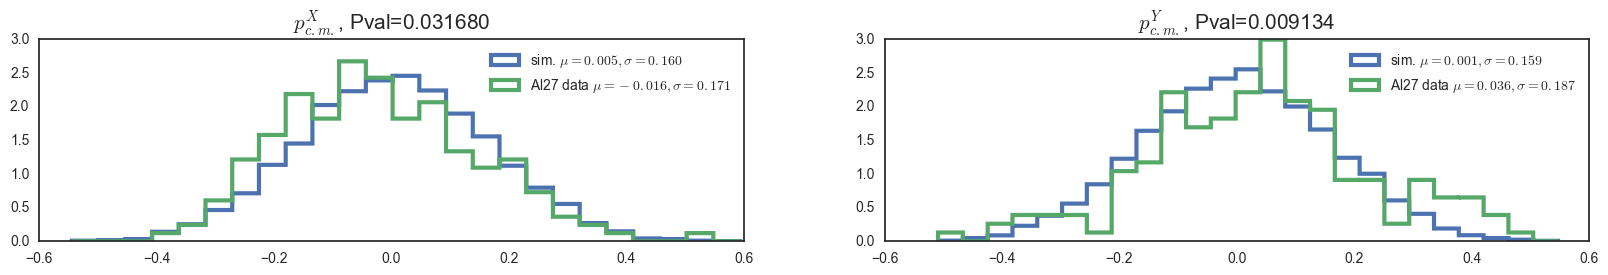

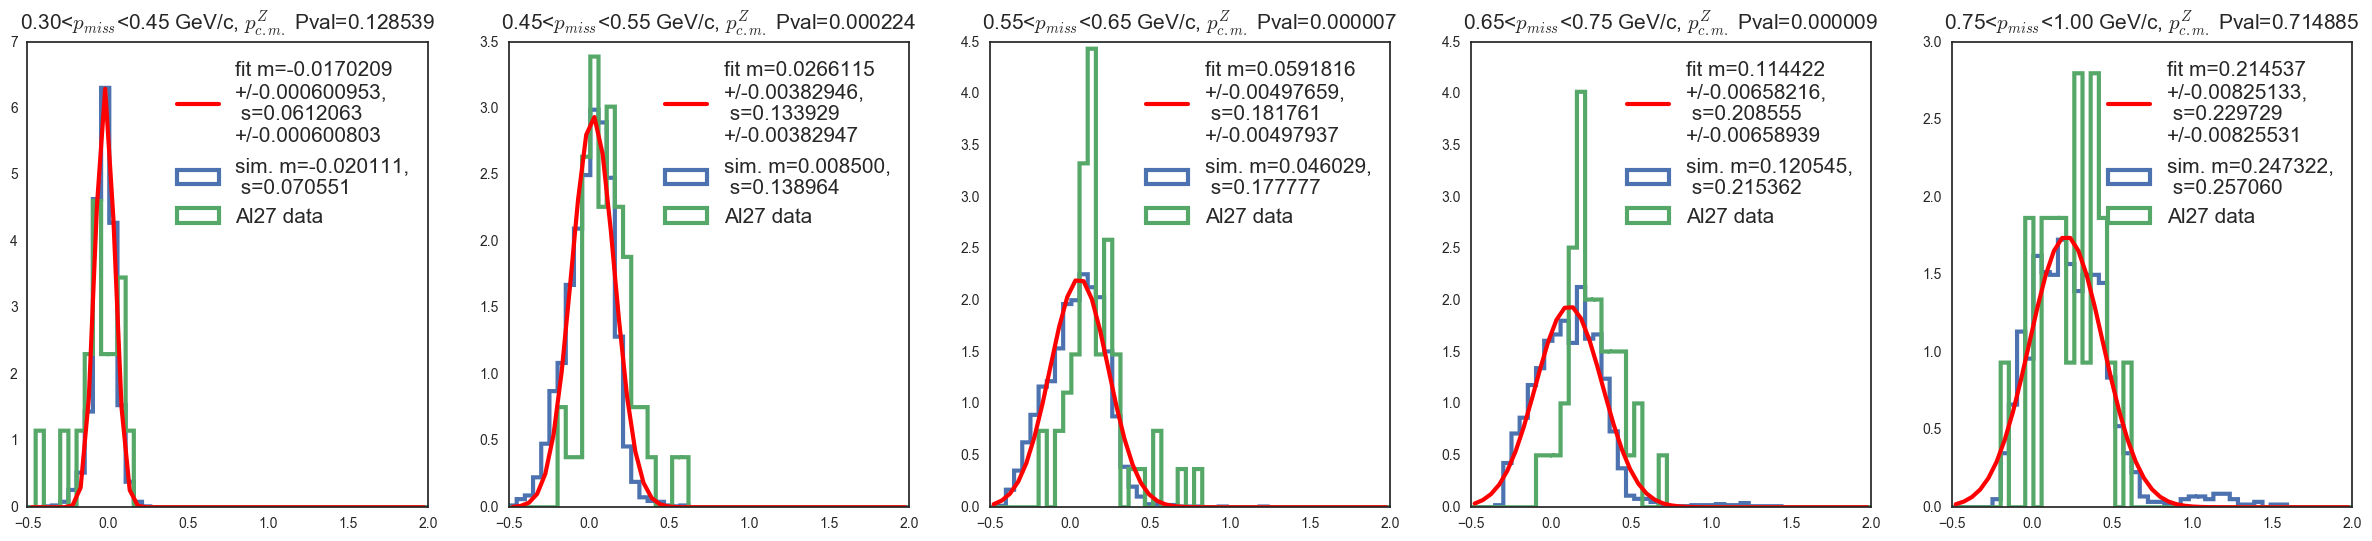

In [8]:
# gen_SigmaX = 0.150412, gen_b1  = 0.570352, gen_b2  = 0.15
ana_sim = TAnalysisEG2( '/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/eg_rootfiles', 'run%d'%100001 )
ks_pval_scores = calc_pval_ks_scores( ana_sim , ana_data )
ana_sim.CloseFile()

fit_sigma_std_ratio: 0.834238428032
fit_sigma_std_ratio: 0.929142515079
fit_sigma_std_ratio: 0.989543185039
fit_sigma_std_ratio: 0.940221058831
fit_sigma_std_ratio: 0.948955619443
ks_pval_scores:
Al27
pcmZ 6.45714549883e-25
Pval_pcmX_pcmY_pcmZ 1.47755287083e-24
Pval_pcmX_pcmY 0.00883426993056


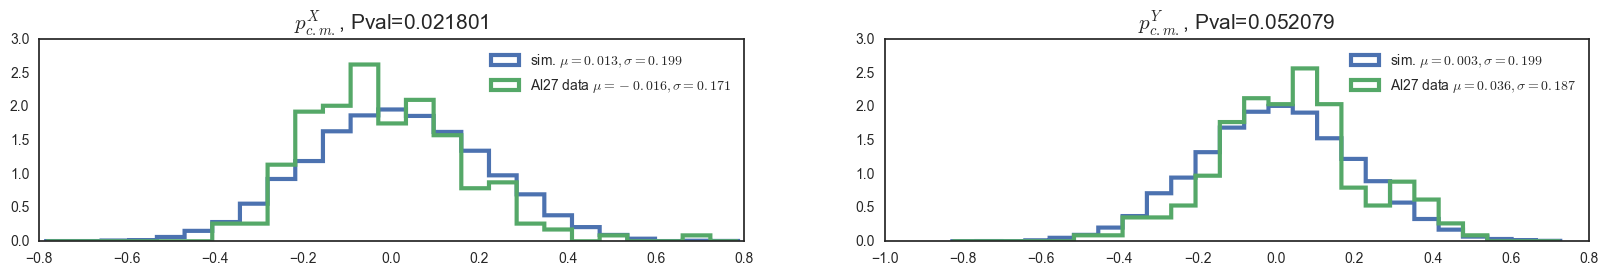

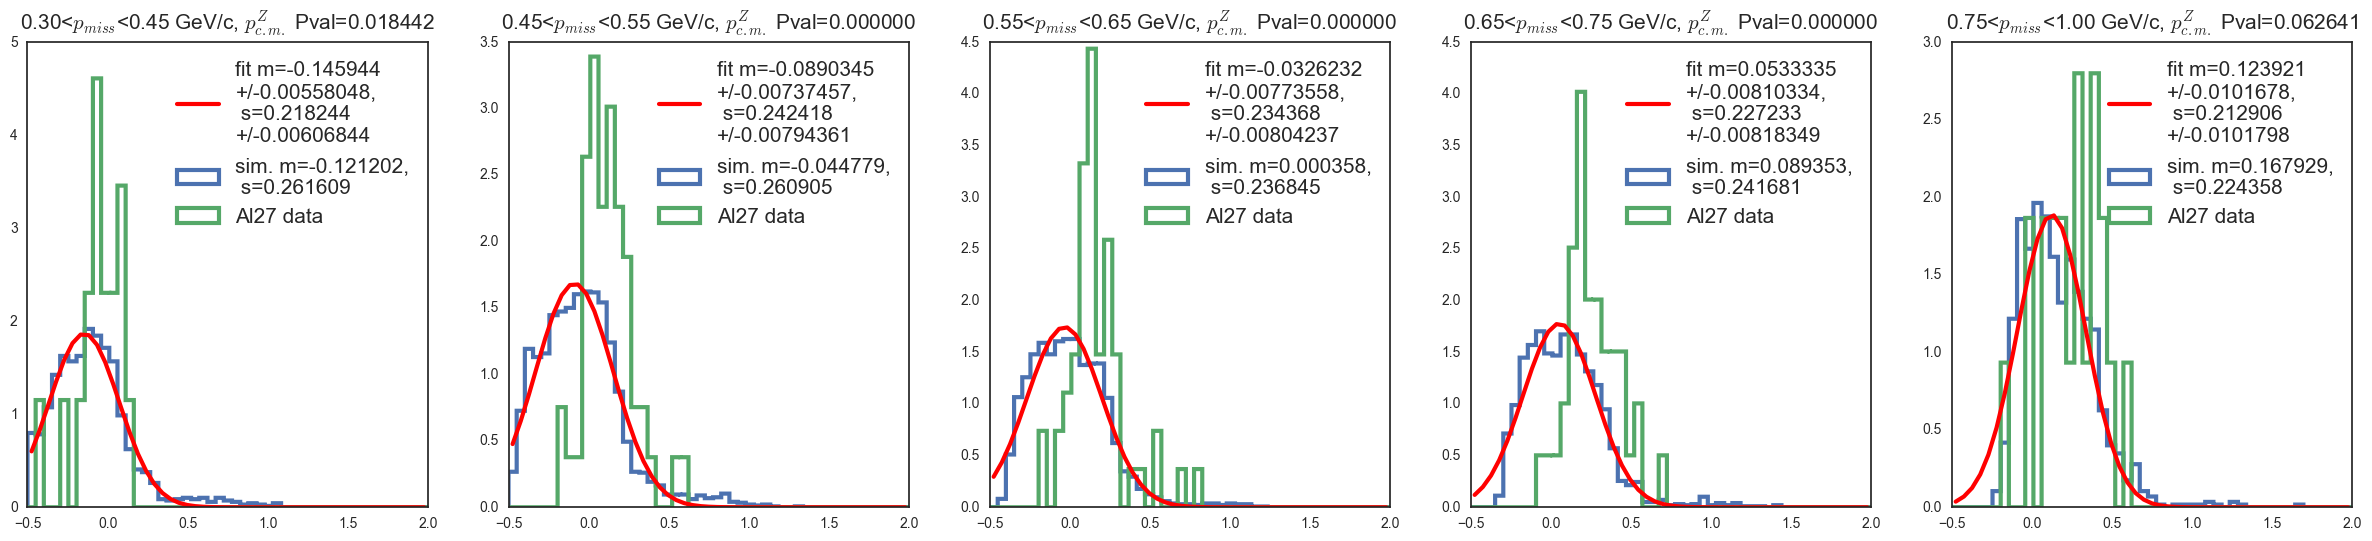

In [39]:
# gen_SigmaX = 0.195473, a1=0.21, a2=0.41, b1=-0.13, b2=-0.03 
ana_sim = TAnalysisEG2( '/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/eg_rootfiles', 'run%d'%100005 )
ks_pval_scores = calc_pval_ks_scores( ana_sim , ana_data )
ana_sim.CloseFile()

fit_sigma_std_ratio: 0.867552357189
fit_sigma_std_ratio: 0.96376878791
fit_sigma_std_ratio: 1.02241222055
fit_sigma_std_ratio: 0.968391154307
fit_sigma_std_ratio: 0.893676716345
ks_pval_scores:
Fe56
pcmZ 2.49157665745e-43
Pval_pcmX_pcmY_pcmZ 2.31221598743e-44
Pval_pcmX_pcmY 0.00018478404011


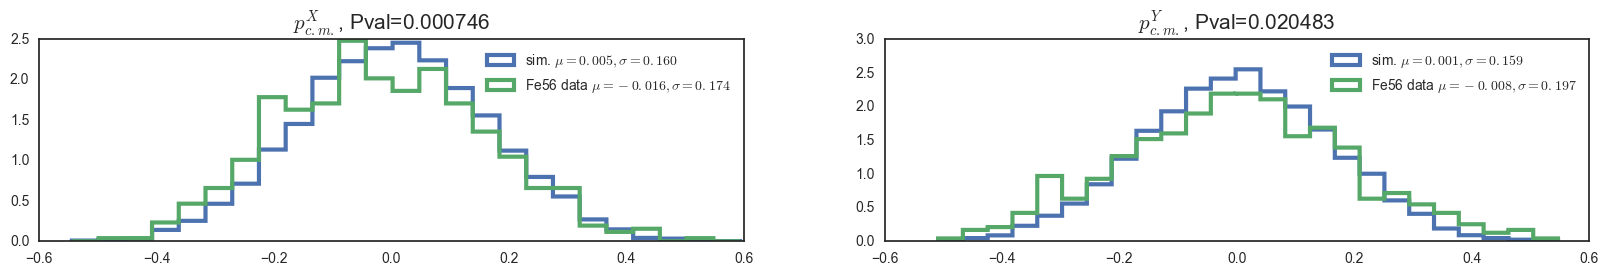

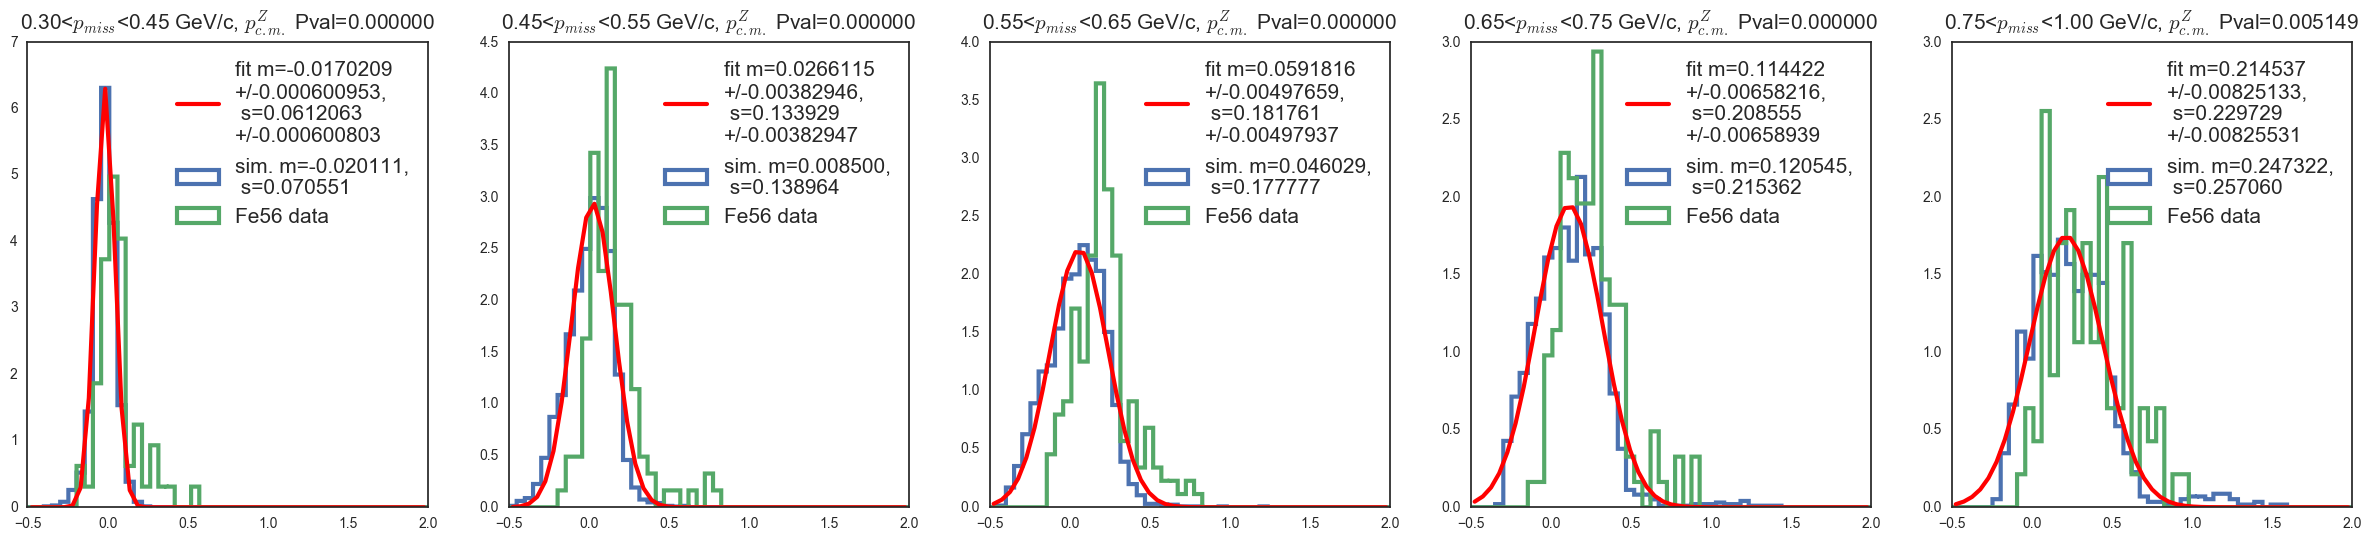

In [35]:
# gen_SigmaX = 0.150412, gen_b1  = 0.570352, gen_b2  = 0.15
ana_sim = TAnalysisEG2( '/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/eg_rootfiles', 'run%d'%100001 )
ks_pval_scores = calc_pval_ks_scores( ana_sim , ana_data )
ana_sim.CloseFile()

fit_sigma_std_ratio: 0.901544234314
fit_sigma_std_ratio: 0.951280175163
fit_sigma_std_ratio: 1.07597544817
fit_sigma_std_ratio: 1.11720315116
fit_sigma_std_ratio: 0.989794278118
ks_pval_scores:
C12
pcmZ 2.31080361145e-27
Pval_pcmX_pcmY_pcmZ 2.14063894329e-28
Pval_pcmX_pcmY 0.00039570578451


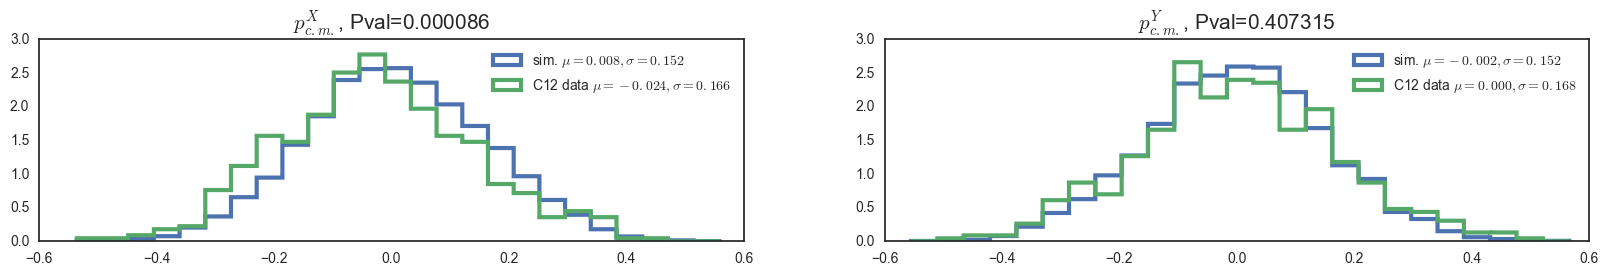

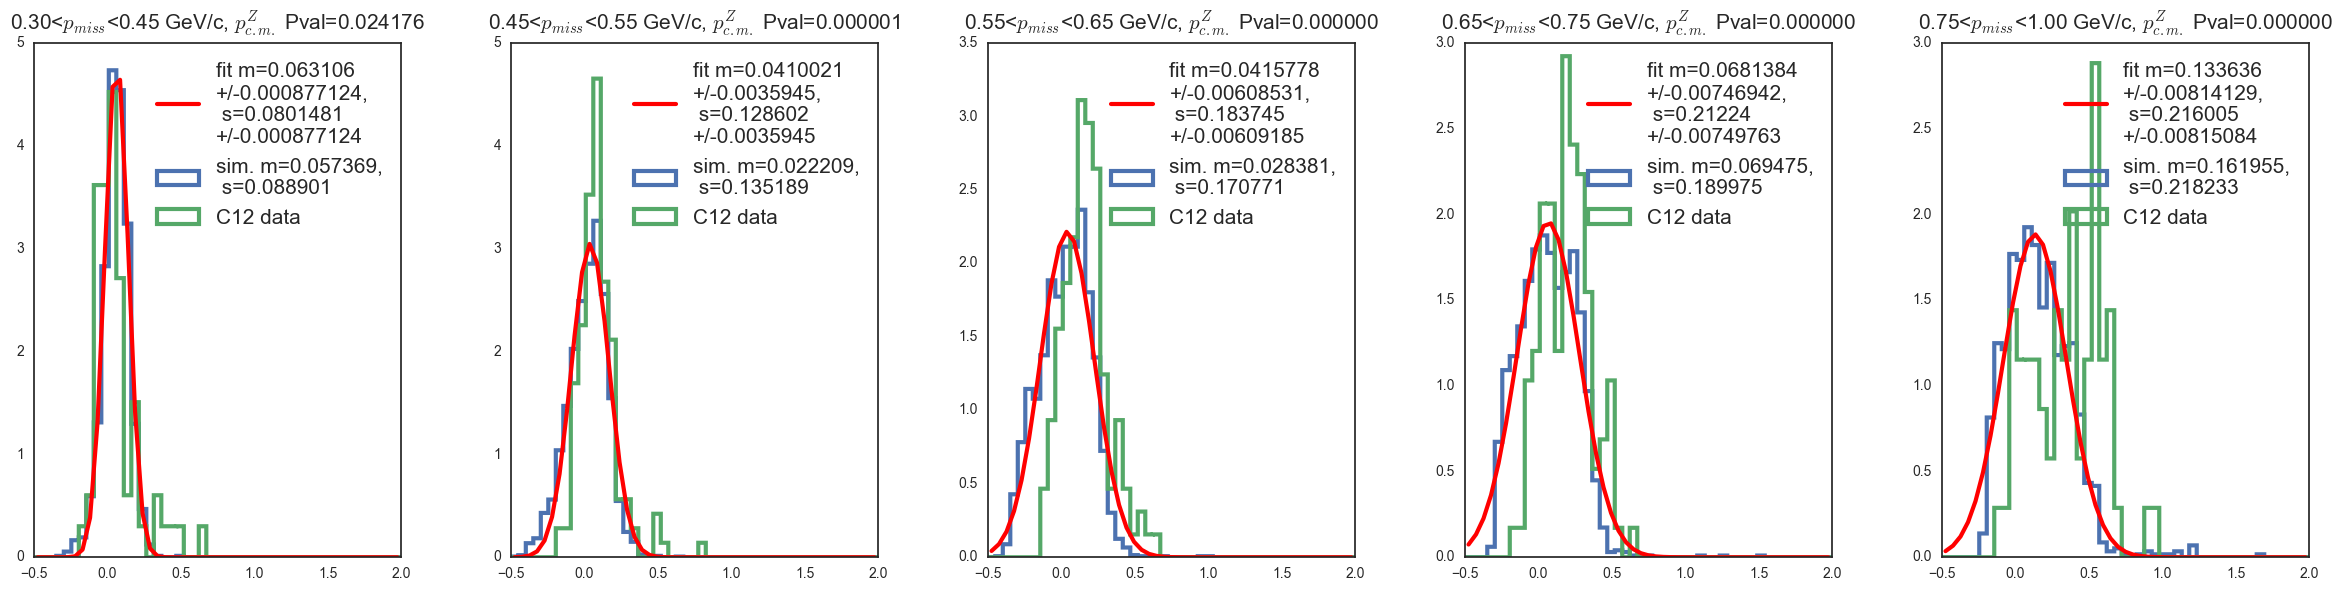

In [22]:
# gen_b1  = -0.170352, gen_b2  = 0.172703
ana_sim = TAnalysisEG2( '/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/eg_rootfiles', 'run%d'%100002 )
ks_pval_scores = calc_pval_ks_scores( ana_sim , ana_data )
ana_sim.CloseFile()

fit_sigma_std_ratio: 0.834451679728
fit_sigma_std_ratio: 0.912884744378
fit_sigma_std_ratio: 0.978631860478
fit_sigma_std_ratio: 0.920044038853
fit_sigma_std_ratio: 0.826380315815
ks_pval_scores:
C12
pcmZ 2.76524115729e-11
Pval_pcmX_pcmY_pcmZ 3.67654007056e-13
Pval_pcmX_pcmY 0.000240444353227


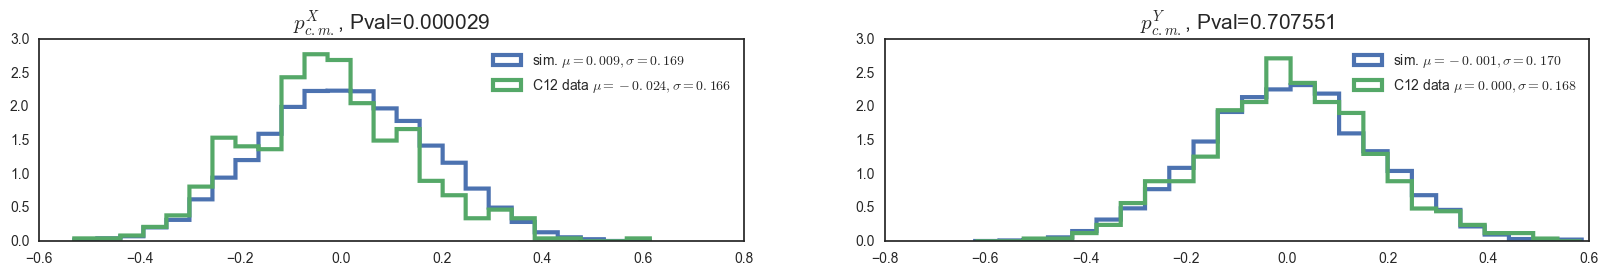

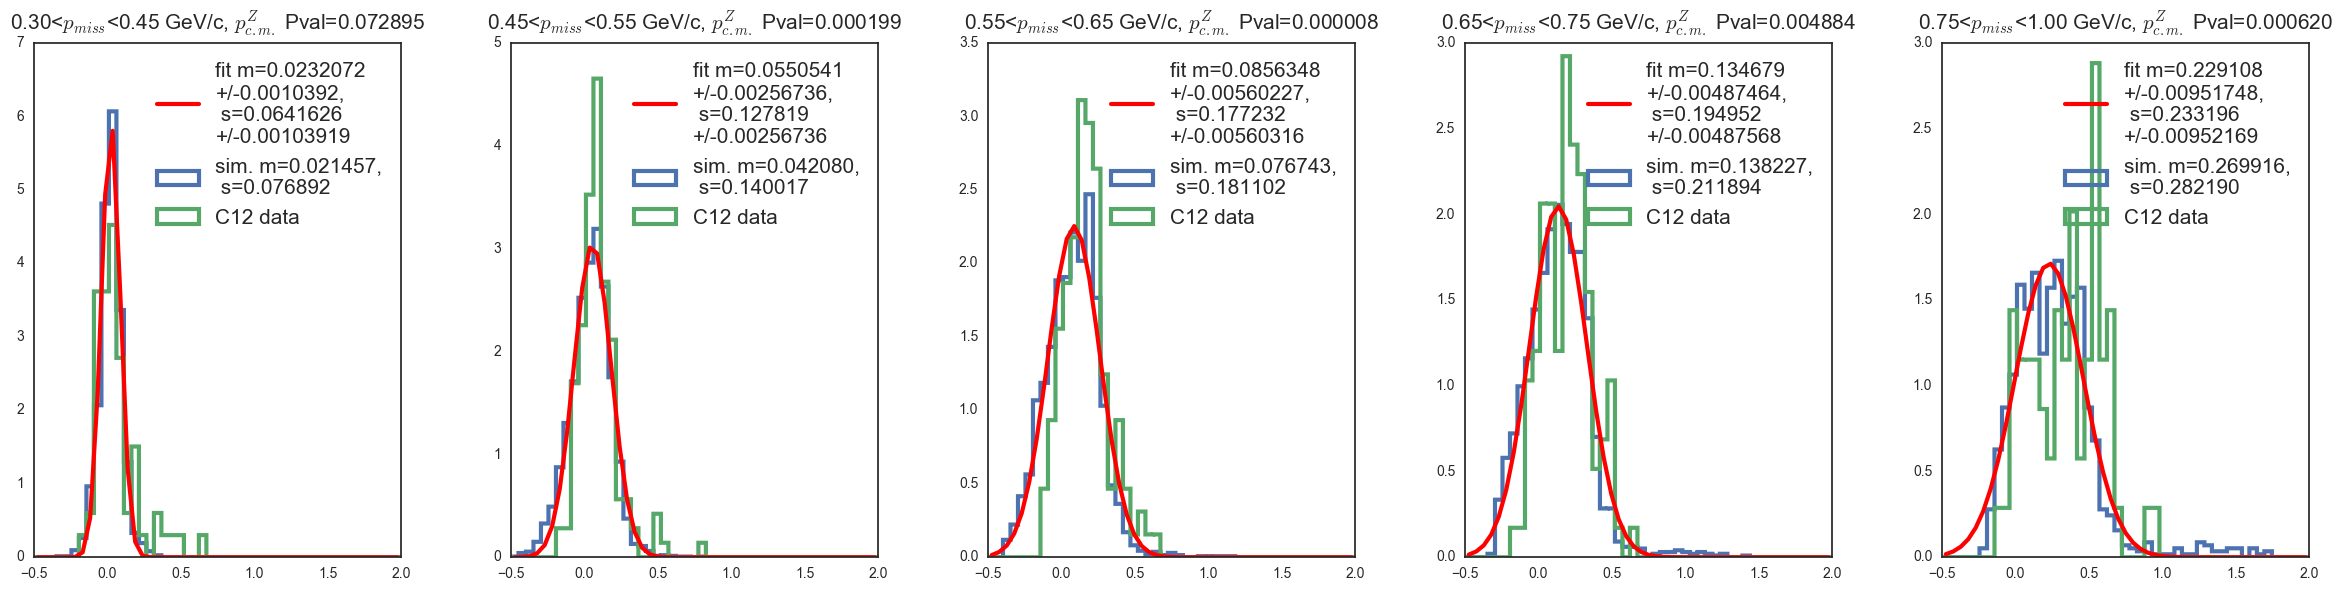

In [25]:
# gen_SigmaX = 0.155, gen_b1  = 0.570352, gen_b2  = 0.2
ana_sim = TAnalysisEG2( '/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/eg_rootfiles', 'run%d'%100003 )
ks_pval_scores = calc_pval_ks_scores( ana_sim , ana_data )
ana_sim.CloseFile()

fit_sigma_std_ratio: 0.790093380976
fit_sigma_std_ratio: 0.987987316981
fit_sigma_std_ratio: 1.08596148202
fit_sigma_std_ratio: 1.10792583706
fit_sigma_std_ratio: 1.02776272542
ks_pval_scores:
Fe56
pcmZ 1.75390120784e-75
Pval_pcmX_pcmY_pcmZ 5.89312061201e-74
Pval_pcmX_pcmY 0.0149876492316


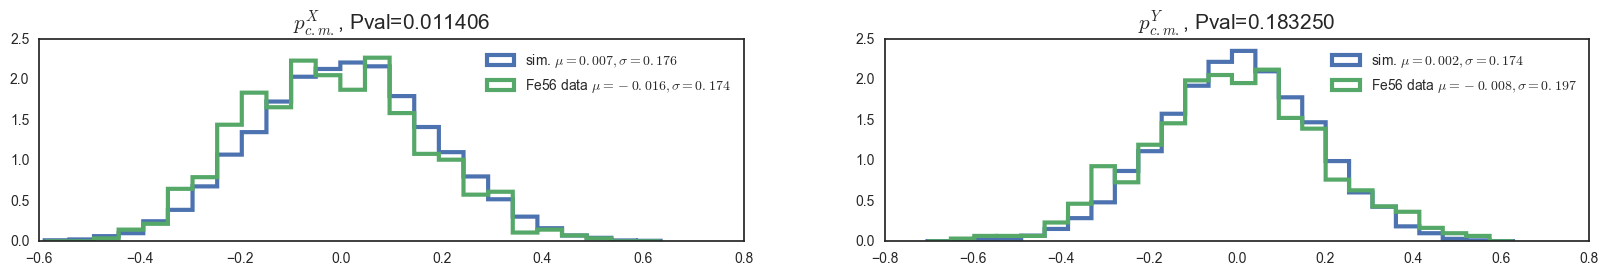

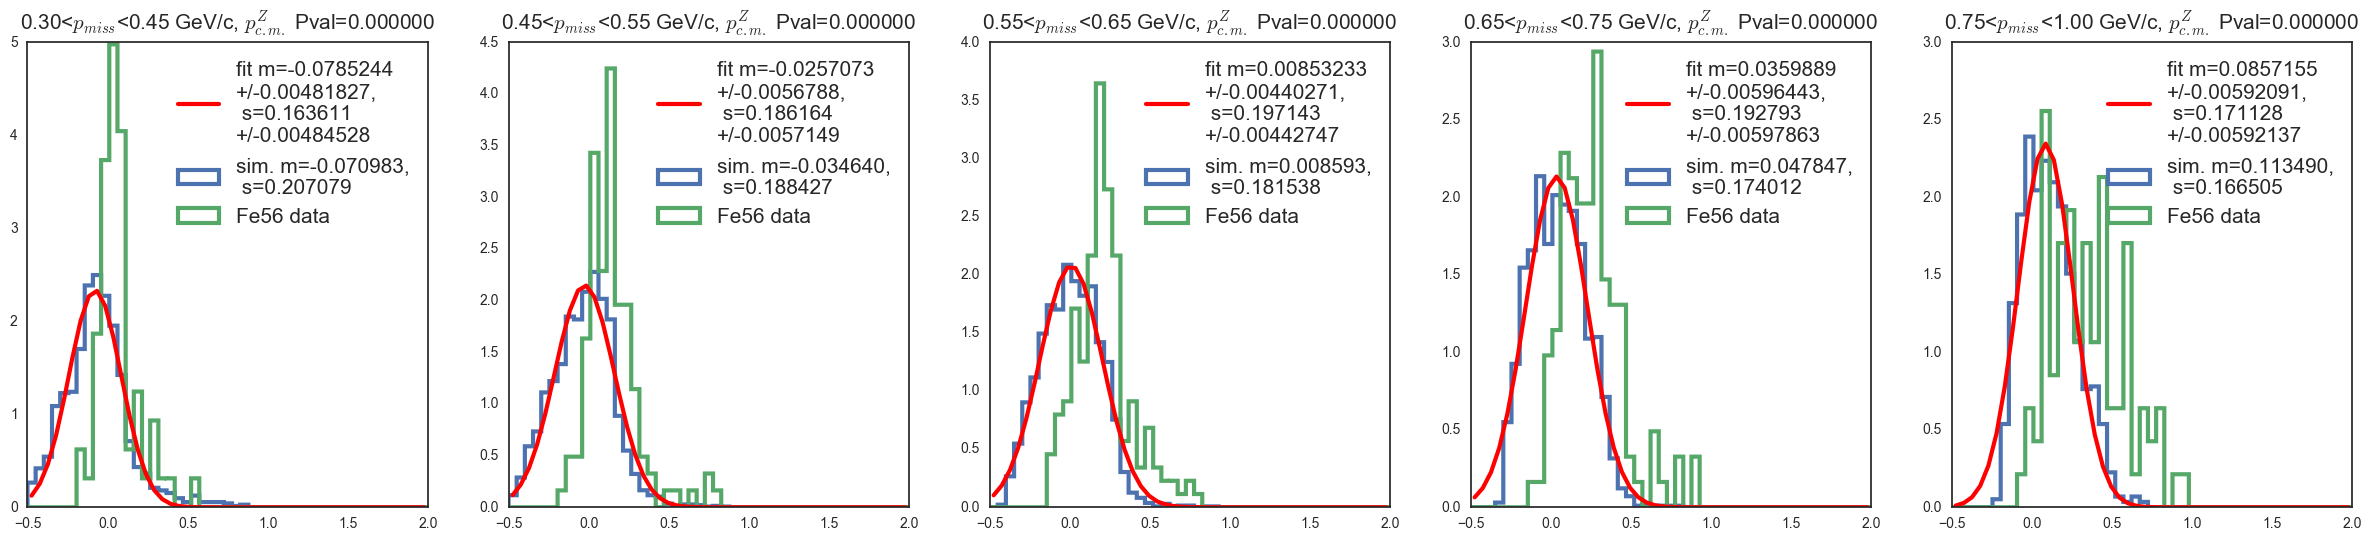

In [36]:
# gen_SigmaX = 0.169497, gen_a1=-0.019627 , gen_a2 = 0.251557, gen_b1 = -0.167962, gen_b2  = 0.035001
ana_sim = TAnalysisEG2( '/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/eg_rootfiles', 'run%d'%100004 )
ks_pval_scores = calc_pval_ks_scores( ana_sim , ana_data )
ana_sim.CloseFile()

In [ ]:
# gen_b1  = 1.270352, gen_b2  = 0.372703
ana_sim = TAnalysisEG2( path + '/eg_rootfiles', 'run%d'%100000 )
ks_pval_scores = calc_pval_ks_scores( ana_sim , ana_data )
ana_sim.CloseFile()

0.0174396470421
mean_fitmean_ratio: 0.957963902483 sigma_fitsigma_ratio: 0.841753433196
0.0252481698076
mean_fitmean_ratio: 5.4102188036 sigma_fitsigma_ratio: 0.969749490594
0.040741766708
mean_fitmean_ratio: 1.45827982089 sigma_fitsigma_ratio: 1.01107006444
0.0562017747648
mean_fitmean_ratio: 1.00379811294 sigma_fitsigma_ratio: 1.037169956
0.0588740250815
mean_fitmean_ratio: 0.894623849601 sigma_fitsigma_ratio: 0.890564947356
ks_pval_scores:
C12
PvalTotal_allPvals 9.15228500886e-33
PvalTotal 9.15228500886e-33
PvalTotalLongitudinal 1.52245098573e-30
PvalTotalTransverse 0.00014692521293


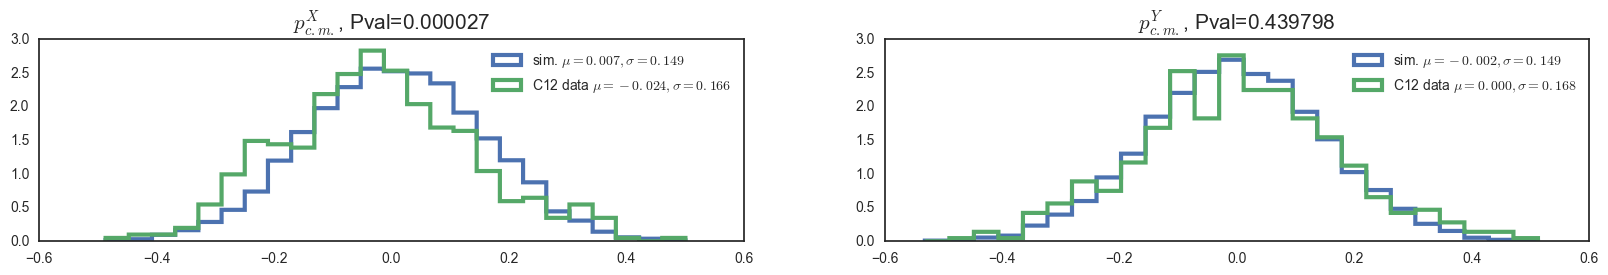

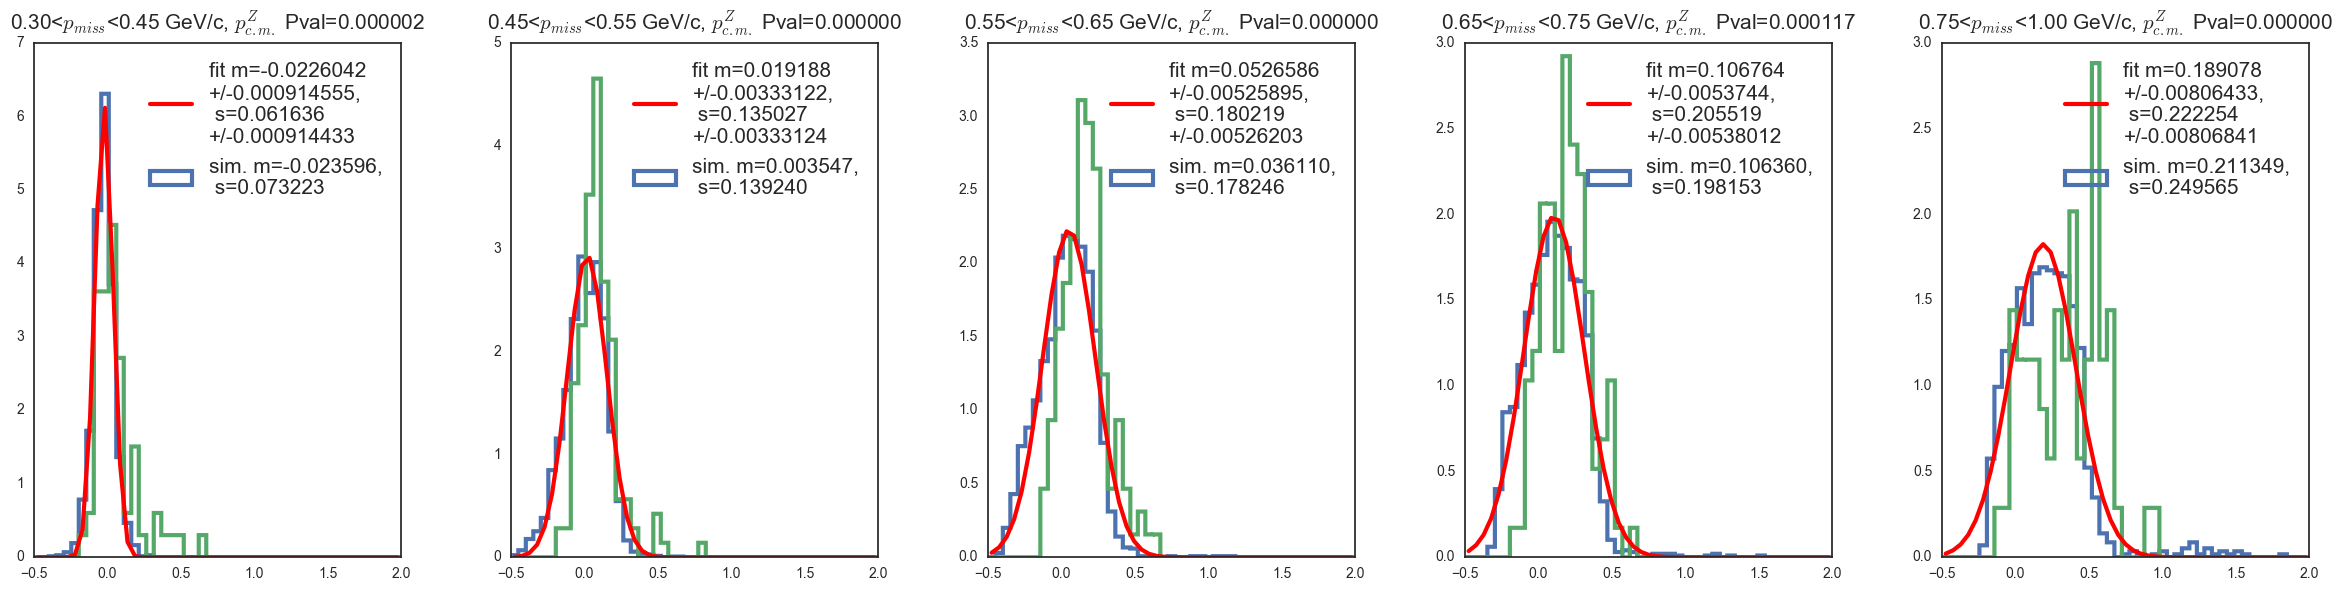

In [112]:
# gen_b1  = 0.5270352, gen_b2  = 0.1372703
ana_sim = TAnalysisEG2( path + '/eg_rootfiles', 'run%d'%100001 )
ks_pval_scores = calc_pval_ks_scores( ana_sim , ana_data )
ana_sim.CloseFile()

# load data

In [8]:
hyperparameters = dict({'start_run':2,
                           'Nruns':1,
                           'range_sigma_t':(0.1  , 0.3),    # 0.160
                           'range_a1':(-0.4 , 1.0),         # 0.143
                           'range_a2':(0.0  , 0.5),         # 0.158
                           'range_b1':(-0.2 , 1.4),         # 0.569
                           'range_b2':(-0.1 , 0.6),         # 0.159
                           'NRand':20,
                           'Ntimes':1,                     # wanted number of events in each Pmiss bin
                           'NgenMax':5000                 # maximal number of attempts
                        })

In [9]:
start_run , Nruns = hyperparameters['start_run'], hyperparameters['Nruns']
NRand = hyperparameters['NRand']
pAcceptacneFile = ROOT.TFile( "/Users/erezcohen/Desktop/DataMining/GSIM_DATA/PrecoilAcceptance.root" )
path = path + "/Analysis_DATA/ppSRCcm"

In [10]:
h = pAcceptacneFile.Get("hRescaled")
gen_events = GenerateEvents( path , 0 , 0 )
gen_events.Set_protonAcceptacne( h )

In [11]:
gen_events.SetInputChain_eep()

In [12]:
gen_events.SetNRand( NRand )
gen_events.Use_protonAcceptacne( True )
gen_events.SetDo_PrecFiducial ( True )
gen_events.SetDo_PrecMinCut ( True )

In [13]:
Ntimes = hyperparameters['Ntimes']
gen_events.SetNeventsPerPmissBin( 71*Ntimes , 143*Ntimes , 132*Ntimes , 96*Ntimes , 56*Ntimes )
gen_events.SetNgenMax( hyperparameters['NgenMax'] )
gen_events.MapInputEntriesInPmissBins()

In [14]:
run = 100000
gen_MeanX  = gen_MeanY = 0
# gen_SigmaX = gen_SigmaY = np.random.uniform( np.min(hyperparameters['range_sigma_t']),np.max(hyperparameters['range_sigma_t']) )
gen_SigmaX = gen_SigmaY = 0.16
gen_a1  = np.random.uniform( np.min(hyperparameters['range_a1']),np.max(hyperparameters['range_a1']) ) # 0.143#
gen_a2  = np.random.uniform( np.min(hyperparameters['range_a2']),np.max(hyperparameters['range_a2']) ) # 0.158#
gen_b1  = np.random.uniform( np.min(hyperparameters['range_b1']),np.max(hyperparameters['range_b1']) ) # 0.569#
gen_b2  = 0.15#np.random.uniform( np.min(hyperparameters['range_b2']),np.max(hyperparameters['range_b2']) ) # 0.159#
print 'run',run,'gen_SigmaX',gen_SigmaX,'gen_a1',gen_a1,'gen_a2',gen_a2,'gen_b1',gen_b1,'gen_b2',gen_b2

run 100000 gen_SigmaX 0.16 gen_a1 0.78665449296 gen_a2 0.345066878385 gen_b1 0.278232888518 gen_b2 0.15


ks_pval_scores:
C12
PvalTotal_allPvals 1.83451057152e-22
PvalTotal 1.83451057152e-22
PvalTotalLongitudinal 3.1377393714e-19
PvalTotalTransverse 2.20176521458e-05


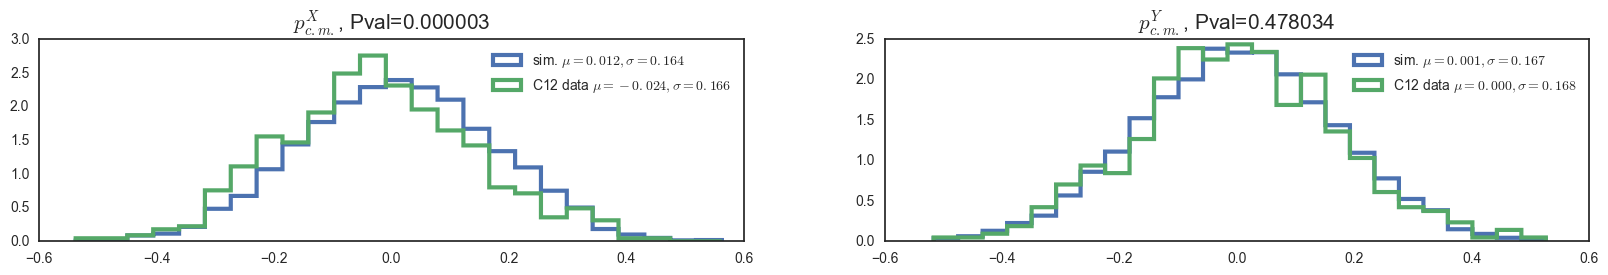

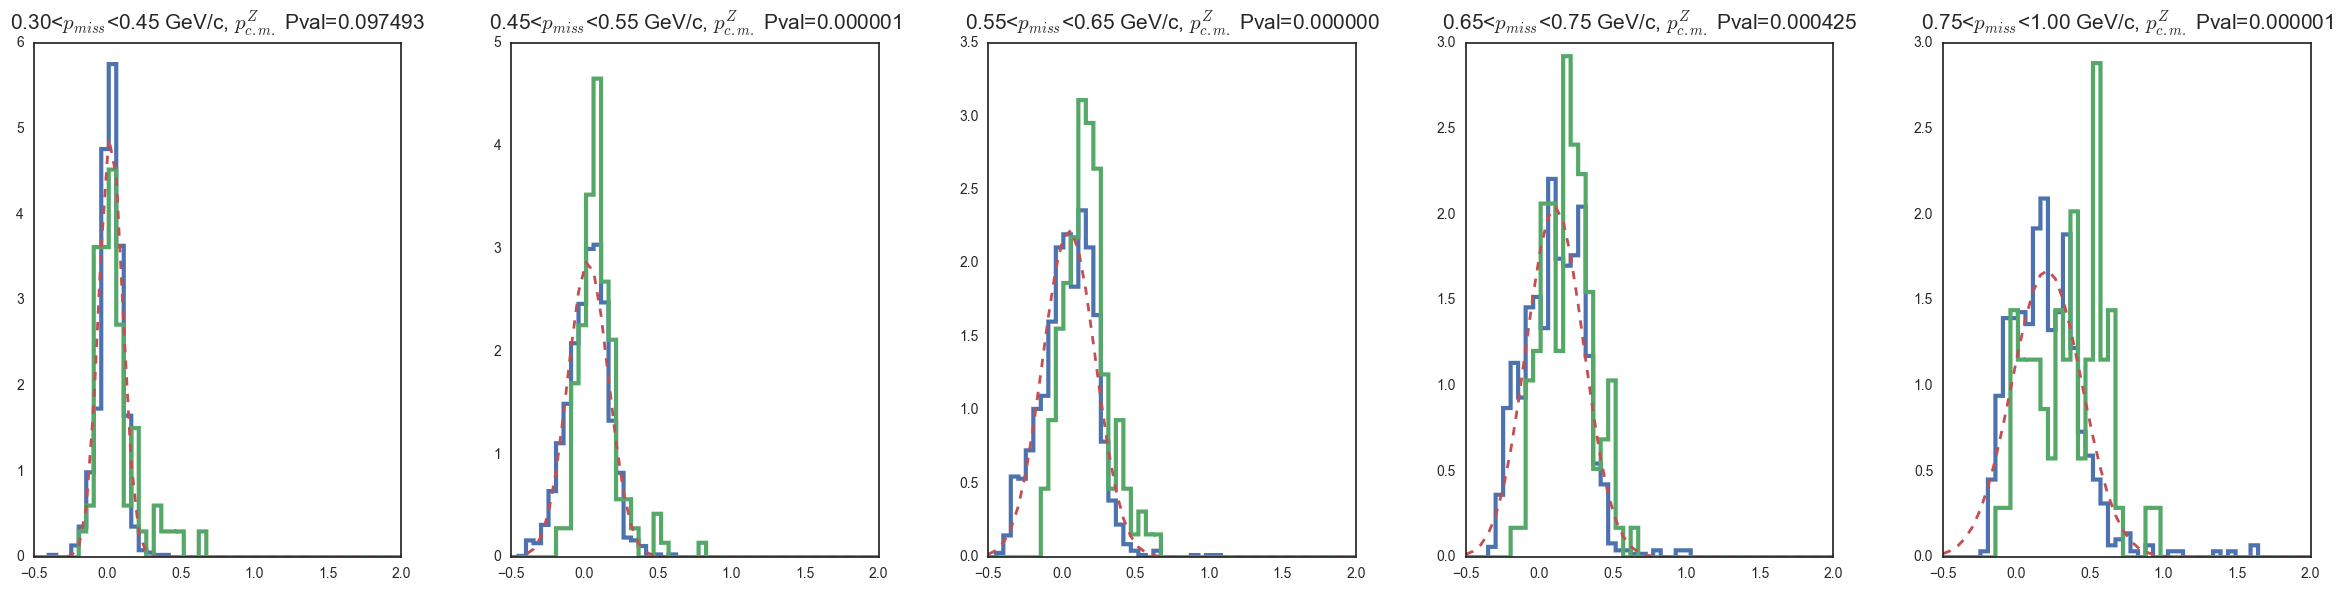

In [40]:
ana_sim = TAnalysisEG2( path + '/eg_rootfiles', 'run%d'%run )
ks_pval_scores = calc_pval_ks_scores( ana_sim , ana_data )
ana_sim.CloseFile()

In [37]:
if a1a2_create_negative_sigma_z( gen_a1 , gen_a2 ) is False:
                
    gen_events.Set_eep_Parameters( gen_MeanX, gen_SigmaX, gen_MeanY, gen_SigmaY, gen_b1, gen_b2, gen_a1, gen_a2 )
    gen_events.InitRun()
#     gen_events.DoGenerate_eepp_from_eep( run )
    
else: print 'a1 (%.2f) and a2(%.2f) create together a negative sigma_z, killing run %d'%( gen_a1 , gen_a2 , run )

a1 (0.31) and a2(0.01) create together a negative sigma_z, killing run 100000


ks_pval_scores:
C12
PvalTotal_allPvals 5.67581481904e-06
PvalTotal 5.67581481904e-06
PvalTotalLongitudinal 0.0314988382869
PvalTotalTransverse 4.02148051686e-06


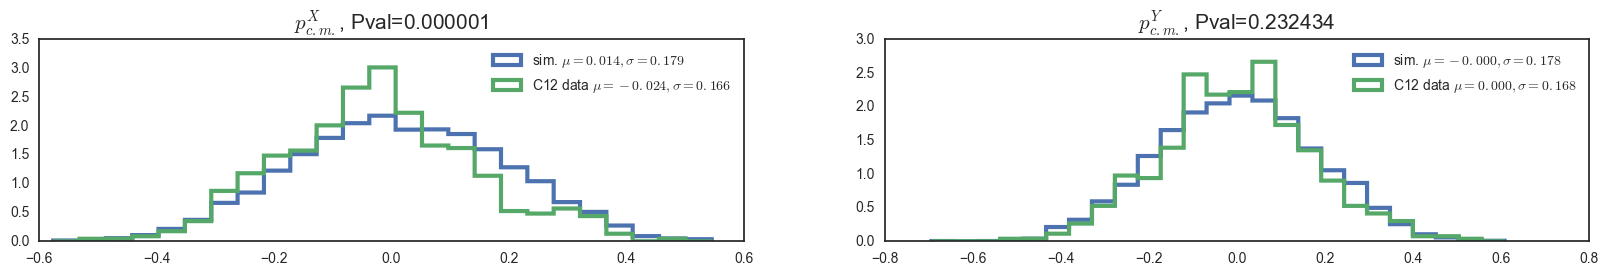

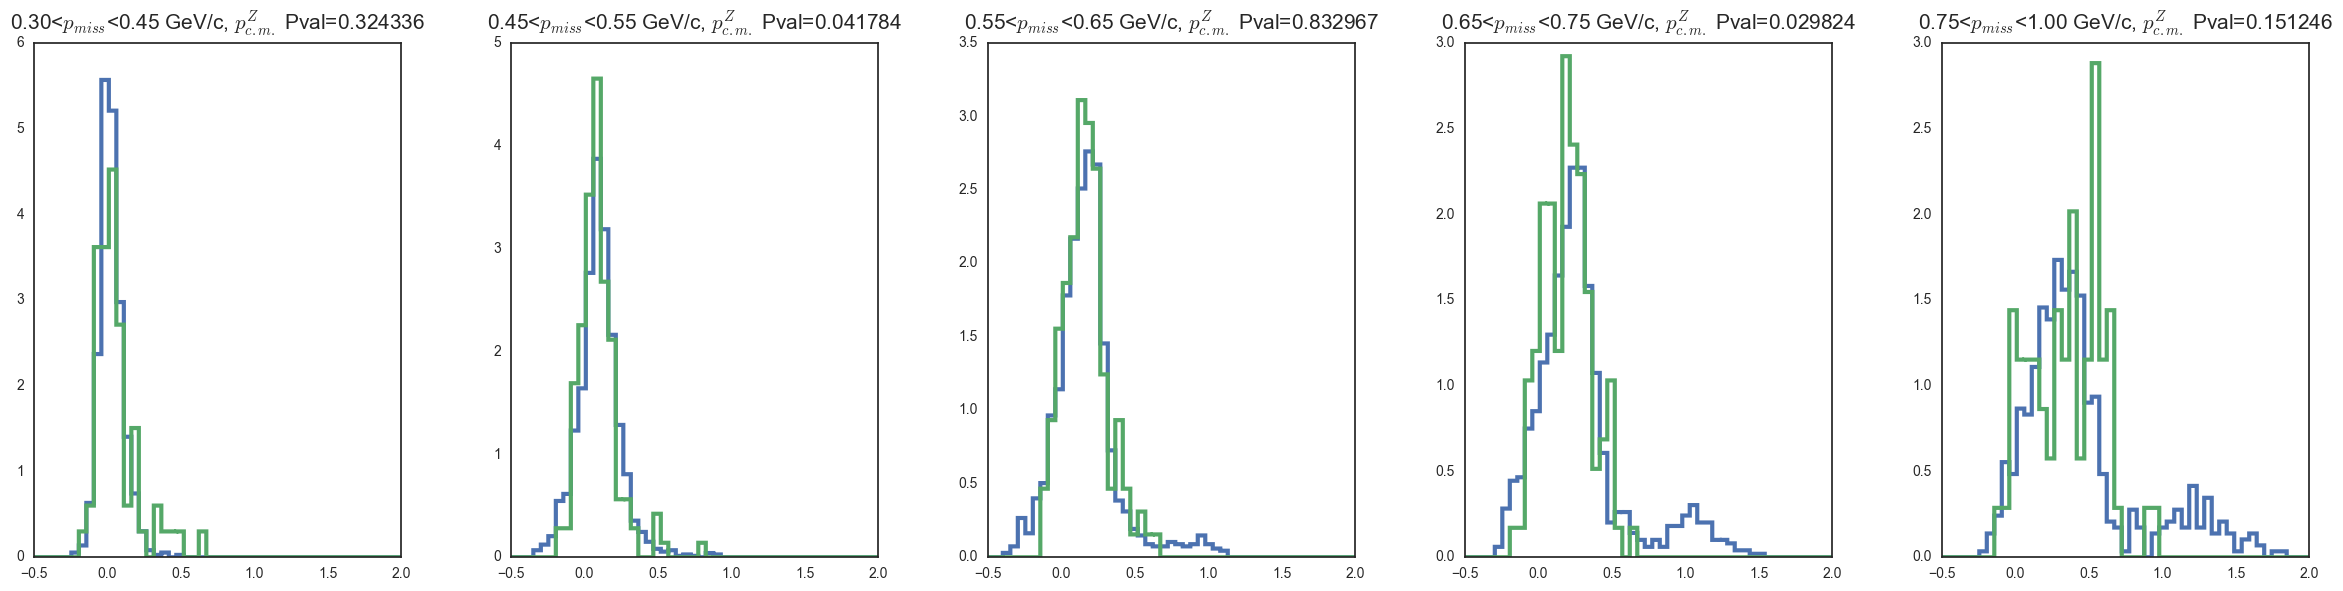

In [34]:
ana_sim = TAnalysisEG2( path + '/eg_rootfiles', 'run%d'%run )
ks_pval_scores = calc_pval_ks_scores( ana_sim , ana_data )
ana_sim.CloseFile()

ks_pval_scores:
C12
PvalTotal_allPvals 2.58200441003e-50
PvalTotal 2.58200441003e-50
PvalTotalLongitudinal 1.31481651333e-42
PvalTotalTransverse 3.60974097401e-10


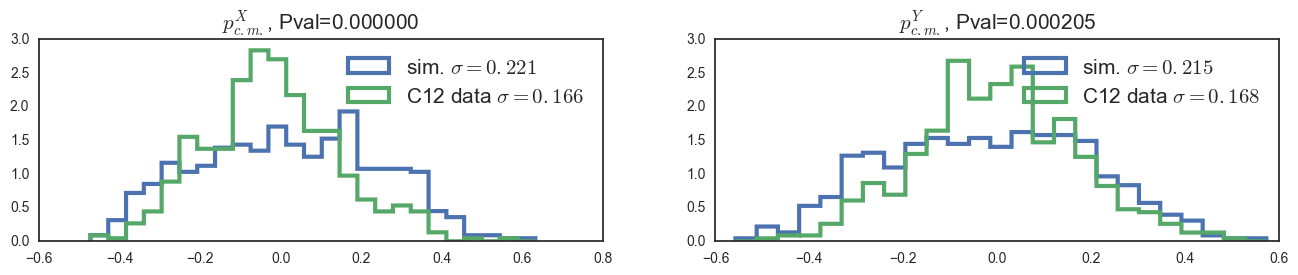

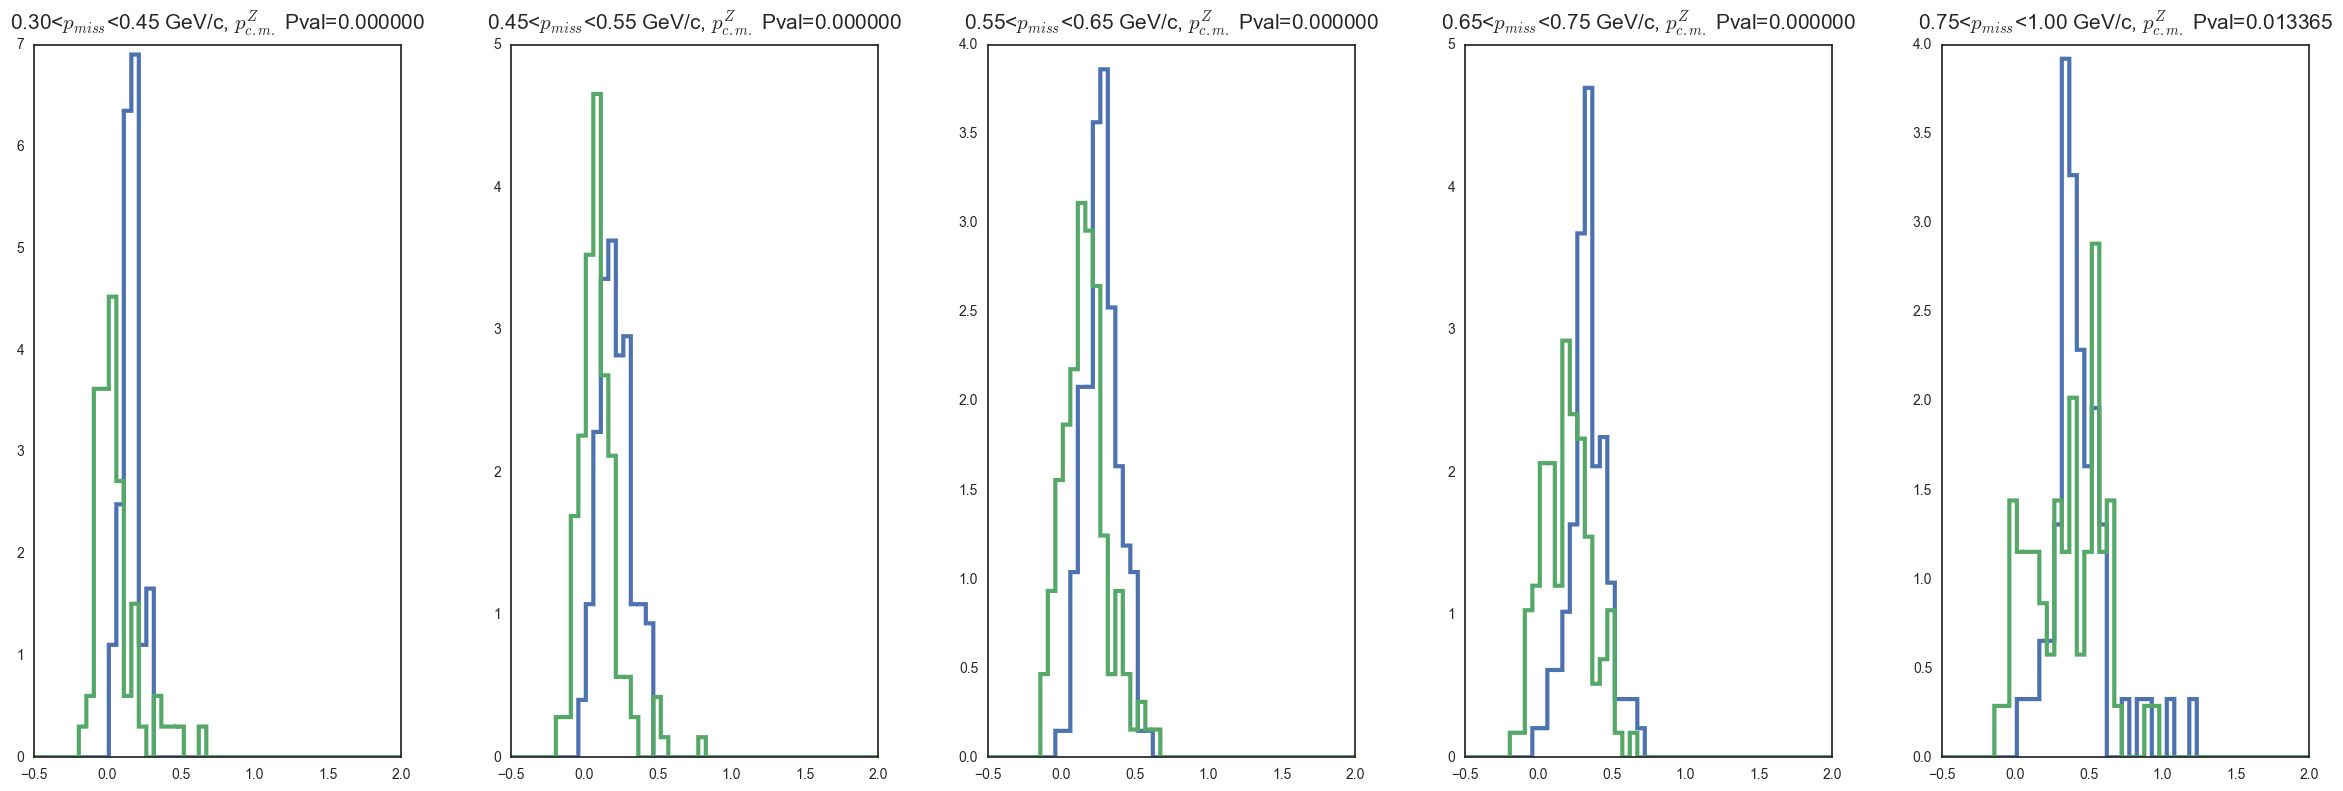

In [14]:
ana_sim = TAnalysisEG2( path + '/eg_rootfiles', 'run%d'%run )
ks_pval_scores = calc_pval_ks_scores( ana_sim , ana_data )
ana_sim.CloseFile()

ks_pval_scores:
C12
PvalTotal_allPvals 3.90817903479e-07
PvalTotal 3.90817903479e-07
PvalTotalLongitudinal 2.48837176996e-05
PvalTotalTransverse 0.00126075467834


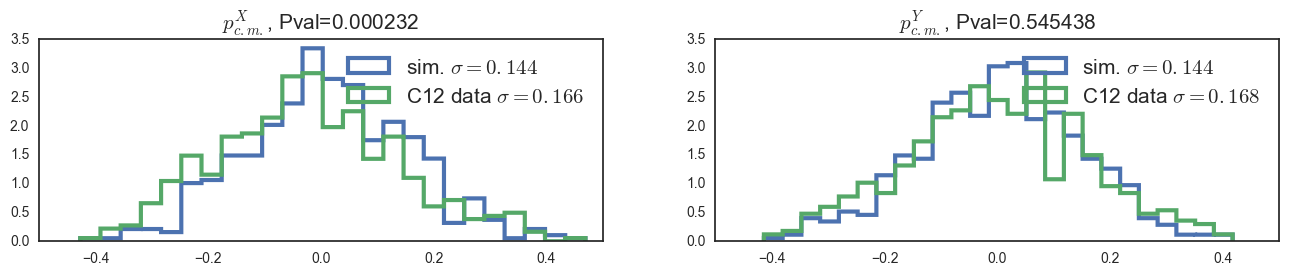

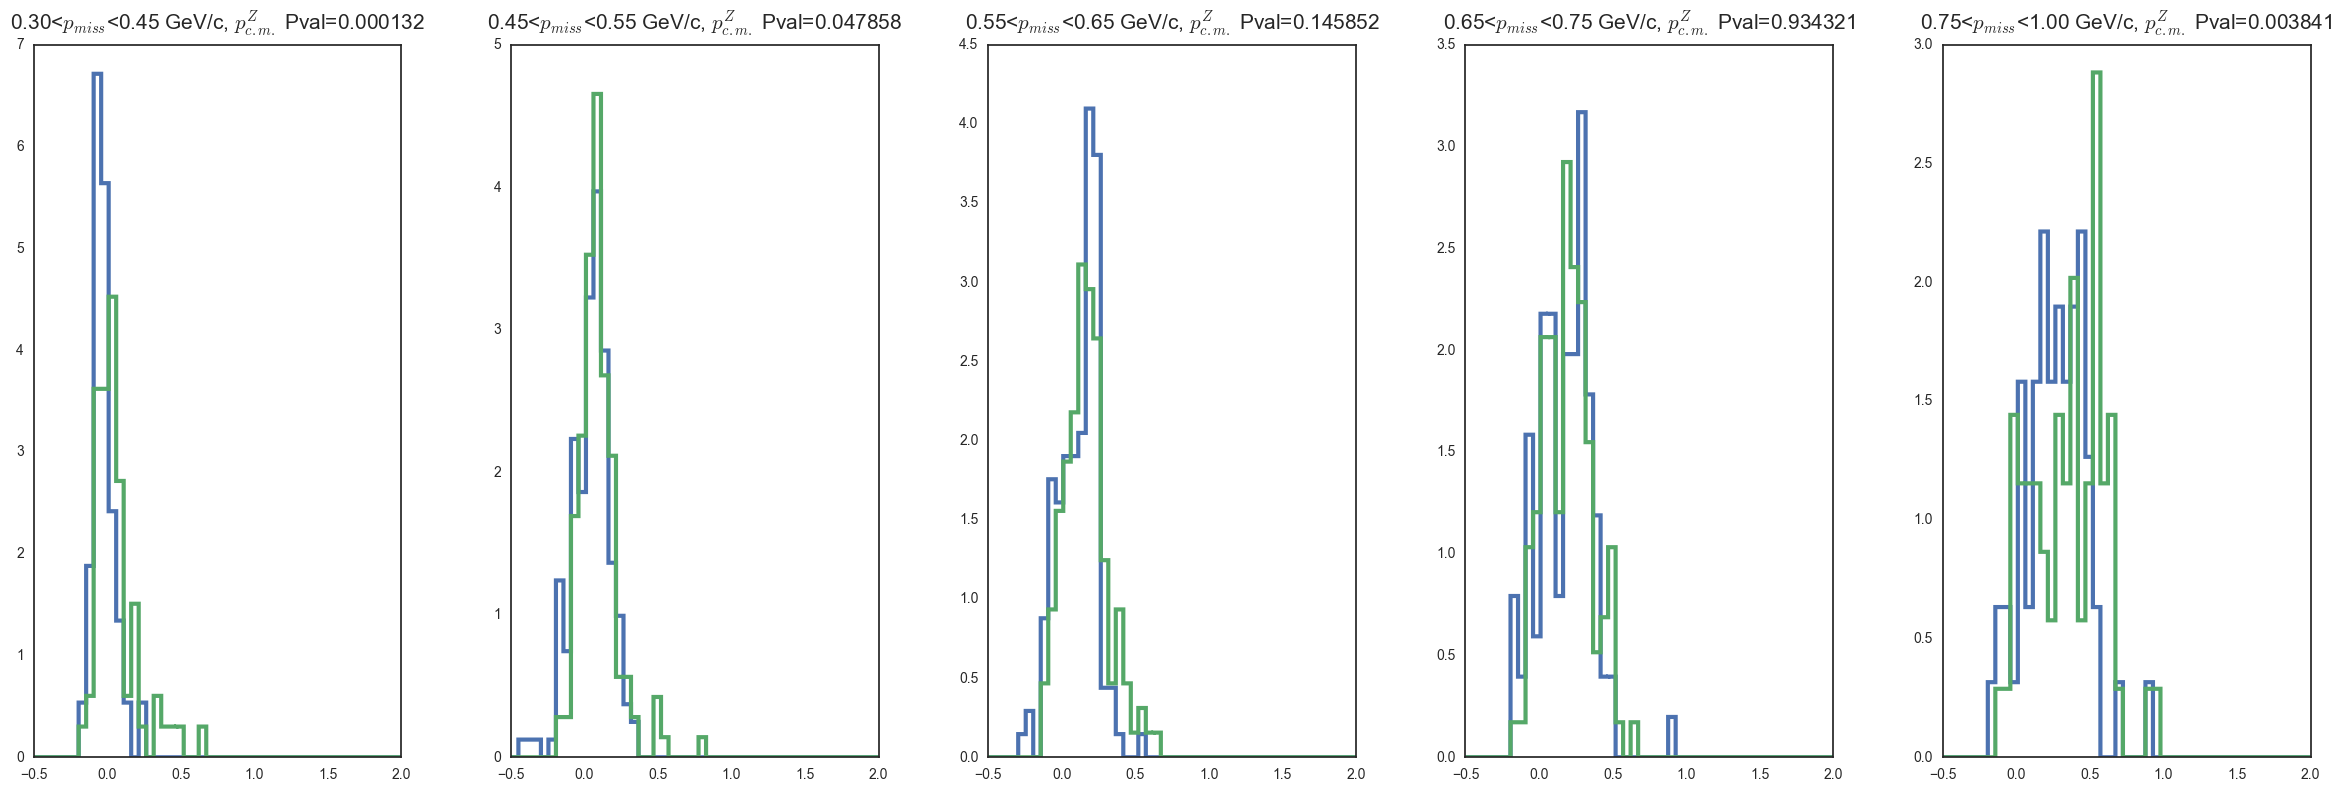

In [17]:
ana_sim = TAnalysisEG2( path + '/eg_rootfiles', 'run%d'%run )
ks_pval_scores = calc_pval_ks_scores( ana_sim , ana_data )
ana_sim.CloseFile()